https://github.com/arviz-devs/simuk/issues/35

In [1]:
from collections.abc import Callable
from typing import Any, Protocol, cast

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
from arviz_base import from_dict
from arviz_plots.plots import plot_ecdf_pit
from jax import Array, random
from jax.typing import ArrayLike
from joblib import Parallel, delayed
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoGuide, AutoNormal
from numpyro.infer.elbo import ELBO
from numpyro.optim import _NumPyroOptim
from simuk.sbc import SBC
from tqdm import tqdm
from typing_extensions import runtime_checkable
from xarray import DataTree

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

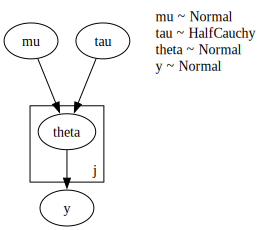

In [2]:
y = jnp.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = jnp.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
j = 8


def model(j: int, sigma: ArrayLike, y: ArrayLike | None = None) -> None:
    mu = numpyro.sample("mu", dist.Normal(loc=0, scale=5))
    tau = numpyro.sample("tau", dist.HalfCauchy(scale=5))

    with numpyro.plate("j", j):
        theta = numpyro.sample("theta", dist.Normal(loc=mu, scale=tau))

    numpyro.sample("y", dist.Normal(loc=theta, scale=sigma), obs=y)


numpyro.render_model(
    model,
    model_args=(j, sigma),
    render_distributions=True,
    render_params=True,
)

In [3]:
%%time

nuts_kernel = NUTS(model)

num_simulations = 100

sbc = SBC(
    nuts_kernel,
    sample_kwargs={"num_warmup": 50, "num_samples": 75},
    num_simulations=num_simulations,
    data_dir={"j": 8, "sigma": sigma, "y": y},
)

sbc.run_simulations()

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]

CPU times: user 1min 39s, sys: 2 s, total: 1min 41s
Wall time: 1min 41s


In [4]:
sbc._extract_variable_names()

In [5]:
sbc.simulations

<xarray.DataTree>
Group: /
│   Attributes:
│       inferece_library:            numpyro
│       inferece_library_version:    0.18.0
│       modeling_interface:          simuk
│       modeling_interface_version:  0.2.0
└── Group: /prior_sbc
        Dimensions:      (chain: 1, draw: 100, theta_dim_0: 8)
        Coordinates:
          * chain        (chain) int64 8B 0
          * draw         (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
          * theta_dim_0  (theta_dim_0) int64 64B 0 1 2 3 4 5 6 7
        Data variables:
            mu           (chain, draw) int32 400B 0 60 67 51 29 56 ... 72 16 44 20 40 53
            tau          (chain, draw) int32 400B 0 17 23 50 45 75 ... 16 0 10 31 33 0
            theta        (chain, draw, theta_dim_0) int32 3kB 75 0 75 0 ... 63 63 57 50
        Attributes:
            created_at:                 2025-03-22T08:35:38.638379+00:00
            creation_library:           ArviZ
            creation_library_version:   0.5.0
            creation_library_language:  Python

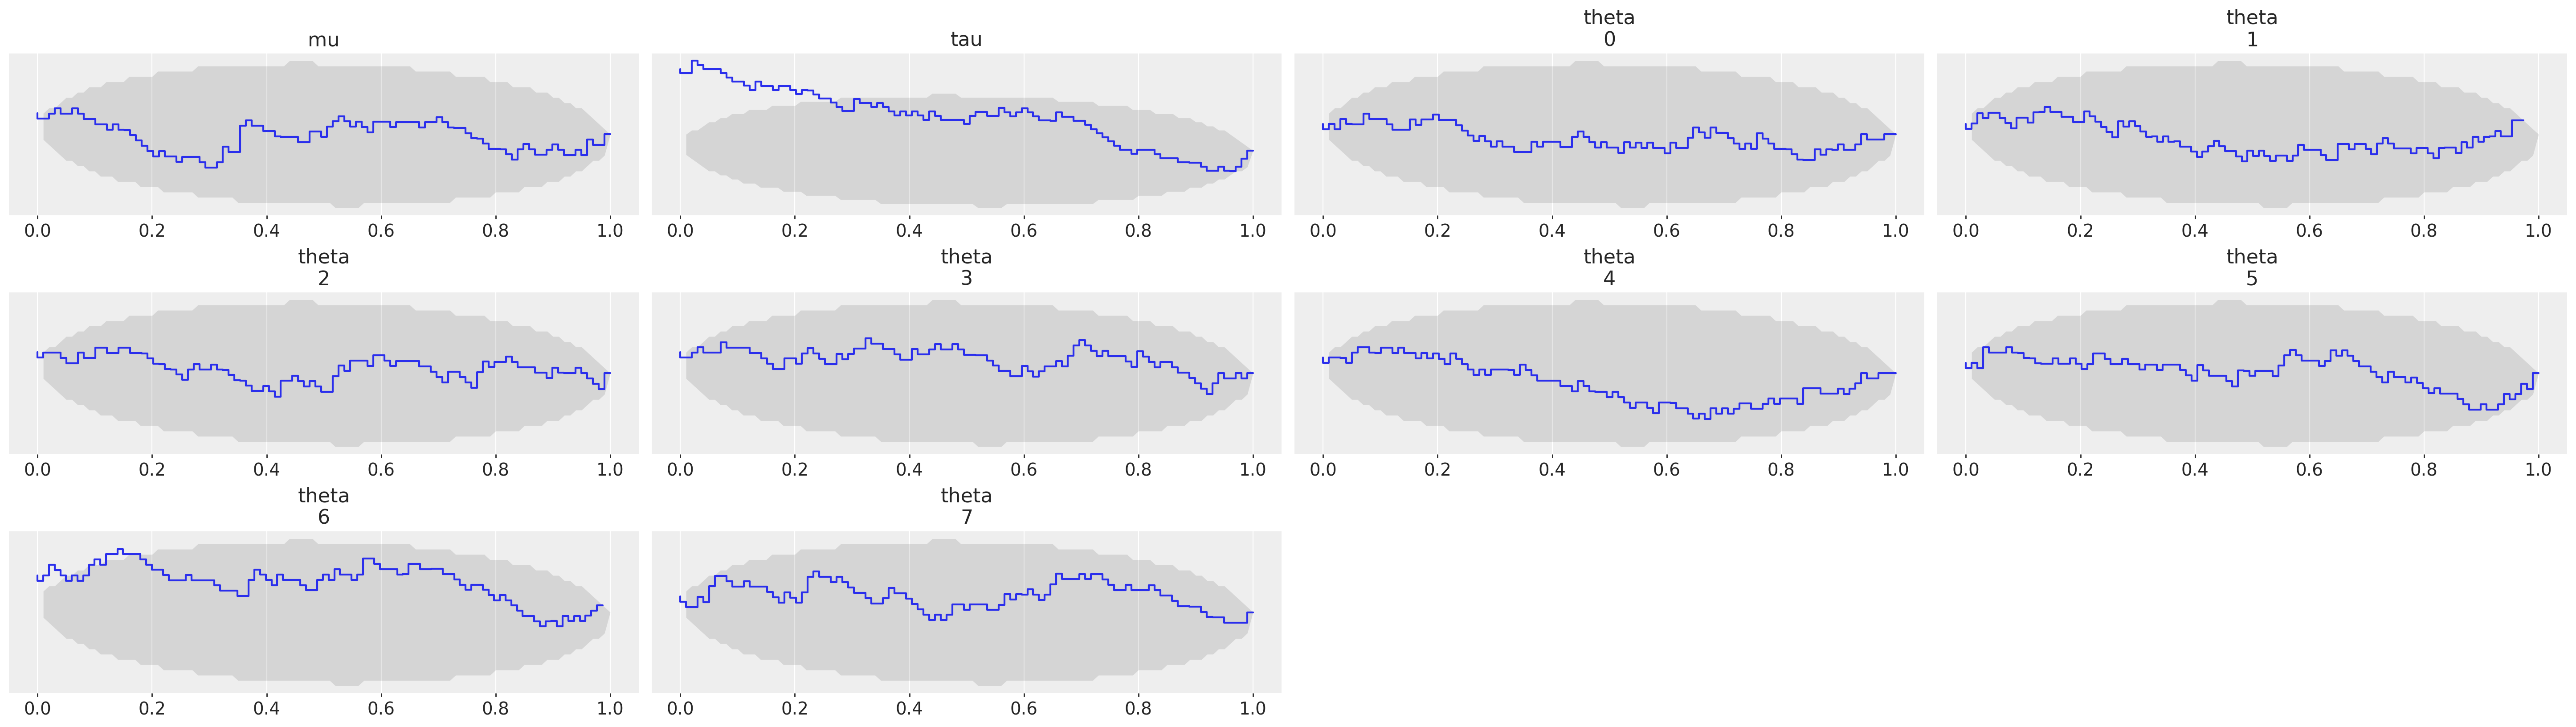

In [6]:
plot_ecdf_pit(
    sbc.simulations, pc_kwargs={"col_wrap": 4}, plot_kwargs={"xlabel": False}
);

In [7]:
def extract_numpyro_variable_names(
    rng_key: Array, model: Callable, model_kwargs: dict[str, Any]
) -> tuple[list[str], list[str]]:
    tr = trace(seed(model, rng_key)).get_trace(**model_kwargs)

    var_names: list[str] = [
        name
        for name, site in tr.items()
        if site["type"] == "sample" and not site.get("is_observed", False)
    ]

    observed_vars: list[str] = [
        name
        for name, site in tr.items()
        if site["type"] == "sample" and site.get("is_observed", False)
    ]

    return var_names, observed_vars


rng_key, rng_subkey = random.split(key=rng_key)
model_kwargs = {"j": 8, "sigma": sigma}
model_kwargs_all = {"j": 8, "sigma": sigma, "y": y}

var_names, observed_vars = extract_numpyro_variable_names(
    rng_key, model, model_kwargs_all
)


print(f"Variable names: {var_names}")
print(f"Observed variables: {observed_vars}")

Variable names: ['mu', 'tau', 'theta']
Observed variables: ['y']


In [8]:
@runtime_checkable
class GetPriorPredictiveSamples(Protocol):
    """Get prior predictive samples from the a data generating process."""

    def __call__(
        self,
        num_simulations: int,
        **kwargs: Any,
    ) -> tuple[dict[str, Array], dict[str, Array]]: ...


def _get_prior_predictive_samples(
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict,
    var_names: list[str],
    observed_vars: list[str],
) -> tuple[dict[str, Array], dict[str, Array]]:
    predictive = Predictive(model=model, num_samples=num_simulations)
    samples = predictive(rng_key, **model_kwargs)
    prior = {k: v for k, v in samples.items() if k in var_names}
    prior_pred = {k: v for k, v in samples.items() if k in observed_vars}
    return prior, prior_pred


get_prior_predictive_samples: GetPriorPredictiveSamples = cast(
    GetPriorPredictiveSamples, _get_prior_predictive_samples
)

In [9]:
@runtime_checkable
class GetPosteriorSamples(Protocol):
    """Get posterior samples from the a data generating process."""

    def __call__(
        self,
        prior_predictive_draw: dict[str, Array],
        num_simulations: int,
        **kwargs: Any,
    ) -> dict[str, Array]: ...


def _get_posterior_samples_nuts(
    prior_predictive_draw: dict[str, Array],
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict,
) -> dict[str, Array]:
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=50, num_samples=num_simulations)
    rng_key, rng_subkey = random.split(key=rng_key)
    mcmc.run(rng_subkey, **model_kwargs, **prior_predictive_draw)
    return az.from_numpyro(mcmc)["posterior"].sel(chain=0)


get_posterior_samples_nuts: GetPosteriorSamples = cast(
    GetPosteriorSamples, _get_posterior_samples_nuts
)


def _get_posterior_samples_svi(
    prior_predictive_draw: dict[str, Array],
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict,
    guide: AutoGuide,
    optimizer: _NumPyroOptim,
    loss: ELBO,
    num_steps: int,
) -> dict[str, Array]:
    svi = SVI(model, guide, optimizer, loss=loss)
    rng_key, rng_subkey = random.split(key=rng_key)
    svi_result = svi.run(
        rng_subkey,
        num_steps,
        progress_bar=False,
        **model_kwargs,
        **prior_predictive_draw,
    )

    predictive = Predictive(
        model=model, params=svi_result.params, num_samples=num_simulations
    )

    rng_key, rng_subkey = random.split(key=rng_key)
    samples = predictive(rng_subkey, **model_kwargs)

    return az.from_dict(posterior={k: v[None, ...] for k, v in samples.items()})[
        "posterior"
    ].sel(chain=0)


get_posterior_samples_svi: GetPosteriorSamples = cast(
    GetPosteriorSamples, _get_posterior_samples_svi
)

In [10]:
def run_simulation(
    get_prior_predictive_samples: GetPriorPredictiveSamples,
    get_prior_predictive_samples_kwargs: dict[str, Any],
    get_posterior_samples: GetPosteriorSamples,
    get_posterior_samples_kwargs: dict[str, Any],
    var_names: list[str],
    num_simulations: int,
) -> DataTree:
    simulations_complete: int = 0

    prior, prior_pred = get_prior_predictive_samples(
        num_simulations=num_simulations, **get_prior_predictive_samples_kwargs
    )

    simulations: dict[str, list[npt.NDArray]] = {name: [] for name in var_names}

    try:

        def process_simulation(
            idx,
            prior_pred,
            prior,
            var_names,
            get_posterior_samples,
            num_simulations,
            get_posterior_samples_kwargs,
        ):
            prior_predictive_draw = {k: v[idx] for k, v in prior_pred.items()}
            posterior_samples = get_posterior_samples(
                prior_predictive_draw, num_simulations, **get_posterior_samples_kwargs
            )

            results = {}
            for name in var_names:
                results[name] = (
                    (posterior_samples[name] < prior[name][idx]).sum(axis=0).to_numpy()
                )
            return results

        results = Parallel(n_jobs=-1)(
            delayed(process_simulation)(
                idx,
                prior_pred,
                prior,
                var_names,
                get_posterior_samples,
                num_simulations,
                get_posterior_samples_kwargs,
            )
            for idx in tqdm(range(num_simulations))
        )

        for result in results:
            for name in var_names:
                simulations[name].append(result[name])
            simulations_complete += 1

    finally:
        simulations = {
            k: np.stack(v[:simulations_complete])[None, :]
            for k, v in simulations.items()
        }

    return from_dict({"prior_sbc": simulations})

In [11]:
rng_key, rng_subkey_prior, rng_subkey_posterior = random.split(key=rng_key, num=3)


simulations_nuts: DataTree = run_simulation(
    get_prior_predictive_samples=get_prior_predictive_samples,
    get_prior_predictive_samples_kwargs={
        "rng_key": rng_subkey_prior,
        "model": model,
        "model_kwargs": model_kwargs,
        "var_names": var_names,
        "observed_vars": observed_vars,
    },
    get_posterior_samples=get_posterior_samples_nuts,
    get_posterior_samples_kwargs={
        "rng_key": rng_subkey_posterior,
        "model": model,
        "model_kwargs": model_kwargs,
    },
    var_names=var_names,
    num_simulations=100,
)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
sample: 100%|██████████| 150/150 [00:01<00:00, 123.51it/s, 15 steps of size 6.63e-01. acc. prob=0.57]


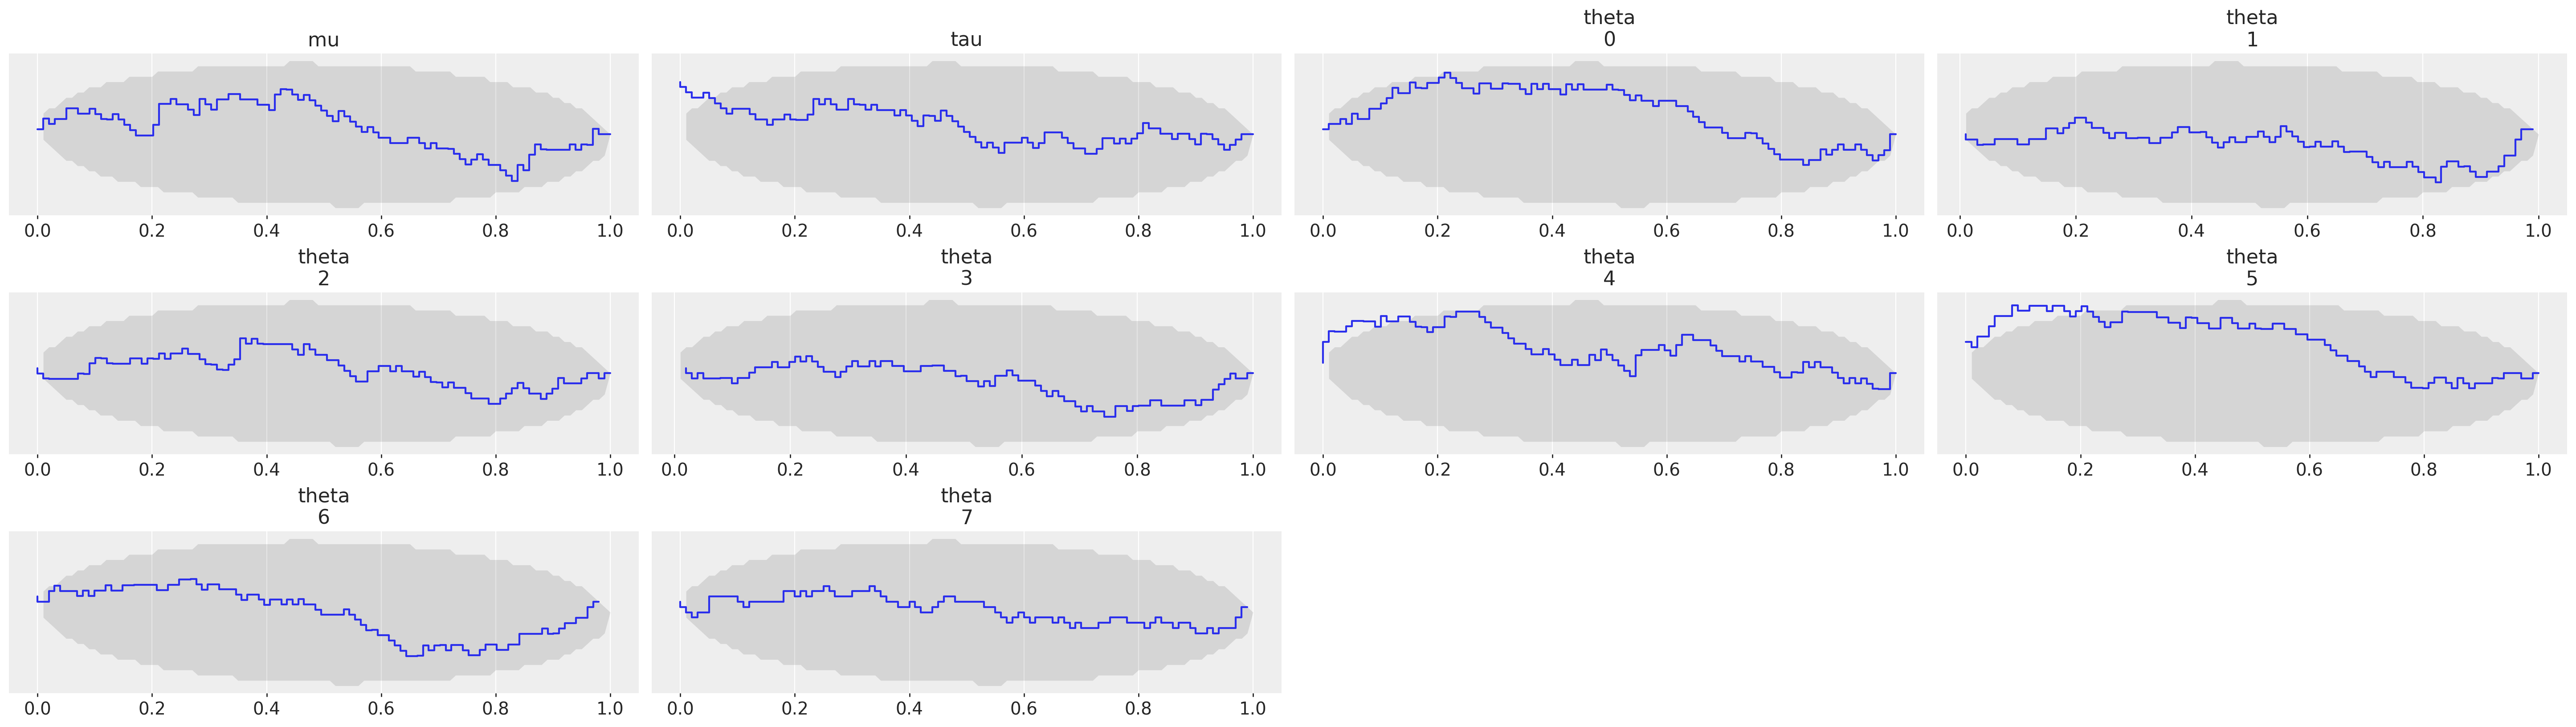

In [12]:
plot_ecdf_pit(
    simulations_nuts,
    pc_kwargs={"col_wrap": 4},
    plot_kwargs={"xlabel": False},
);

In [13]:
simulations_svi: DataTree = run_simulation(
    get_prior_predictive_samples=get_prior_predictive_samples,
    get_prior_predictive_samples_kwargs={
        "rng_key": rng_subkey_prior,
        "model": model,
        "model_kwargs": model_kwargs,
        "var_names": var_names,
        "observed_vars": observed_vars,
    },
    get_posterior_samples=get_posterior_samples_svi,
    get_posterior_samples_kwargs={
        "rng_key": rng_subkey_posterior,
        "model": model,
        "model_kwargs": model_kwargs,
        "guide": AutoNormal(model),
        "optimizer": numpyro.optim.Adam(step_size=0.01),
        "loss": Trace_ELBO(),
        "num_steps": 1_000,
    },
    var_names=var_names,
    num_simulations=100,
)

100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


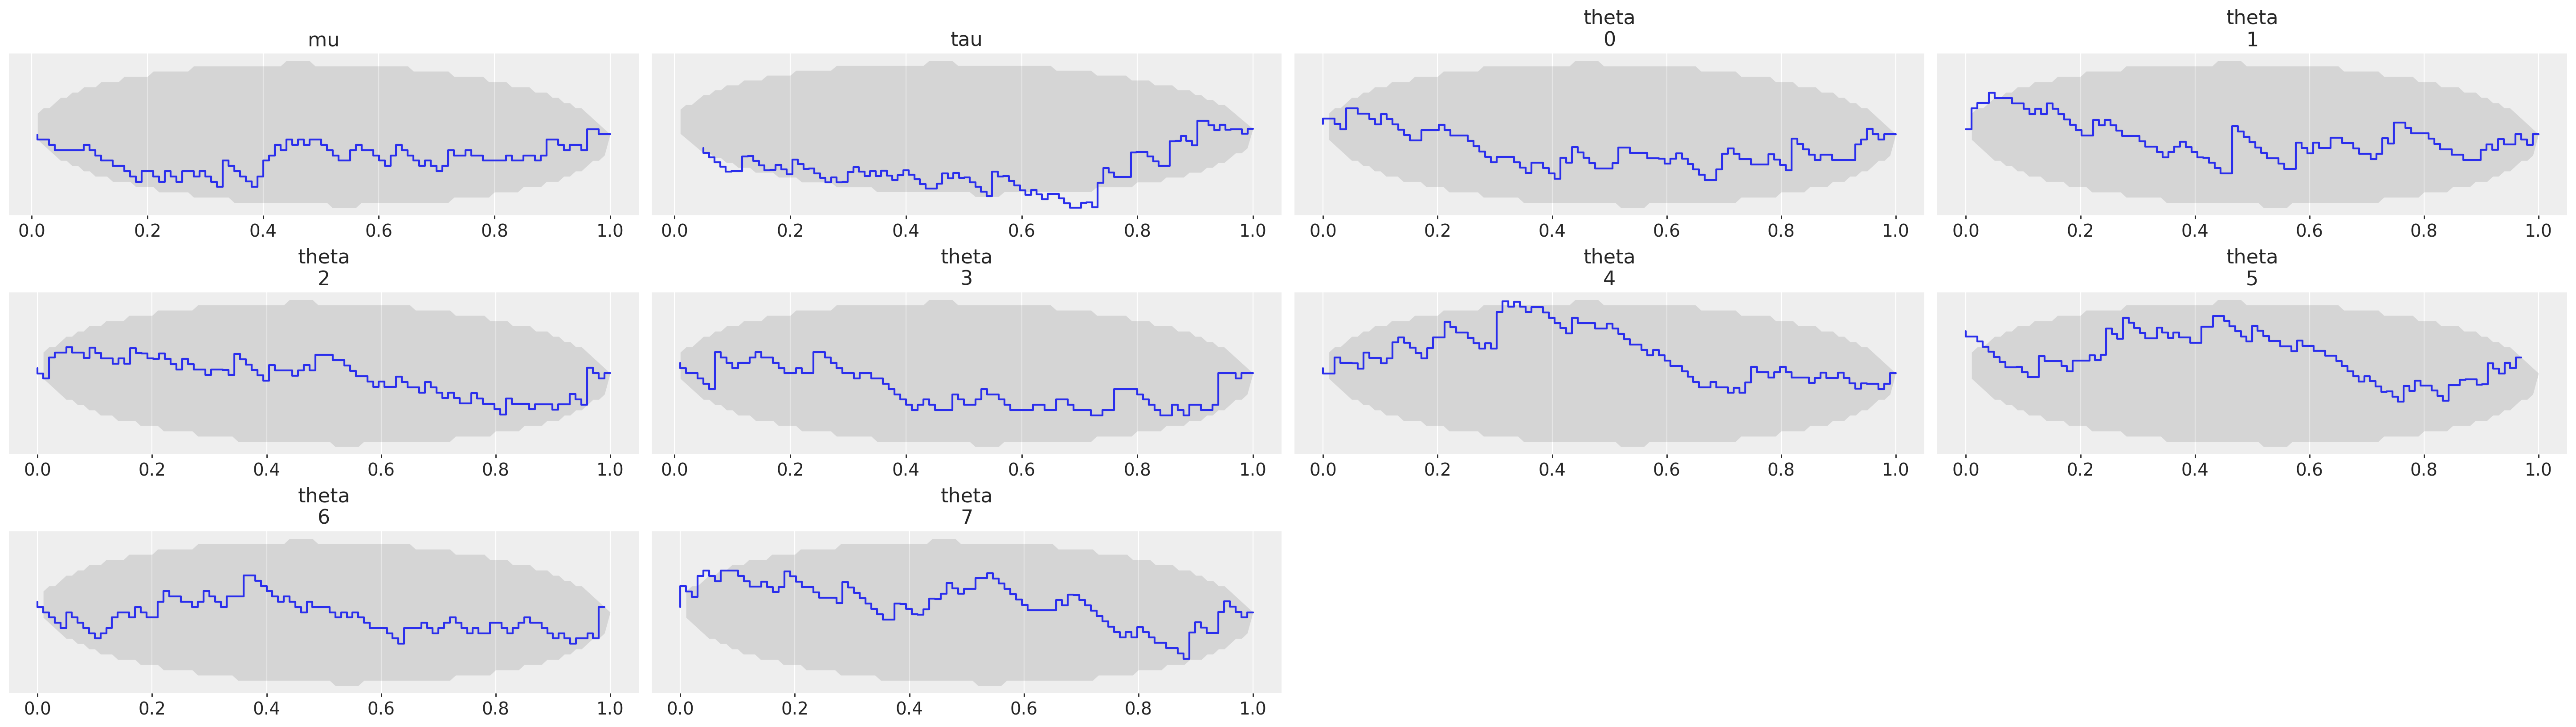

In [14]:
plot_ecdf_pit(
    simulations_svi,
    pc_kwargs={"col_wrap": 4},
    plot_kwargs={"xlabel": False},
)